In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statistics import NormalDist
import glob
from scipy.stats import ttest_ind

In [2]:

label_f = '~/Ephys/Data/all_pats_bipole_soz_labels.csv'
label_df = pd.read_csv(label_f, header=None)
label_df.columns = ['subj','bipole','label']
label_df.head(4)


,subj,bipole,label
0,Epat31,AH3-AH4,1
1,Epat31,AH4-AH5,1
2,Epat31,AH5-AH6,1
3,Epat31,PH1-PH2,1


In [3]:
def split_bipole(bip_df: pd.DataFrame):
    """splits the bipole column of a bipole df
    duplicates rows

    """
    assert 'bipole' in bip_df.columns, "Need bipole column!"

    contact1 = bip_df.bipole.apply(lambda x: x.split("-")[1].strip(" "))
    contact2 = bip_df.bipole.apply(lambda x: x.split("-")[1].strip(" "))
# python resultAggregator.py -s 'Epat38' -p '/mnt/ernie_main/Ghassan/ephys/data/Epat38'
    df2 = bip_df.copy(deep=True)

    bip_df['contact'] = contact1
    df2['contact'] = contact2


    return pd.concat([bip_df,df2])

def map_label(label):
    label = int(label)
    match label:
        case 0:
            return "NIZ"
        case 1:
            return 'SOZ'
        case 2:
            return 'PZ'
        case 3:
            return 'IZ'
        
def merge_label(subj_df: pd.DataFrame, label_df: pd.DataFrame, leftcol: str, rightcol: str ) -> pd.DataFrame:
    """Merges contact label into the subj_df for both stim and response regions

    Args:
        subj_df (pd.DataFrame): dataframe with SPES data, could be CRP, raw SPES, etc
        as long as each row has an entry for a bipole (or monopolar) contact to merge on. 
        ASSUMES 'subj' is a column for sanity checks.
       
        label_df (pd.DataFrame): labels designating 'SOZ', 'NIZ', 'PZ', should be originating 
        from the 'all_pats_bipole.csv', may contain more than one subject, but ASSUMES 'subj' is a column.

        leftcol (str): column of subject bipoles, could be stim, or resp, will be renamed
        'leftcol_label'

       merge_labeleturns:
        pd.DataFrame: subj df with columns for labels
    """
    assert 'subj' in subj_df.columns, "Need a 'subj' column! in subj_df"
    assert 'subj' in label_df.columns, "Needa 'subj' column in label_df"
    assert 'label' in label_df.columns, "Need a label to merge into subj_df, check label_df!"
    assert subj_df.subj.values[0] in set(label_df.subj.values) ,"Subject missing from label df!"
    assert len(set(subj_df.subj)) == 1, 'Can only merge one subject at a time!'
    
    subj = subj_df.subj.values[0]
    label_df = label_df[label_df.subj == subj]
    subj_df = subj_df.merge(label_df[[rightcol, 'label']], left_on=leftcol, right_on=rightcol)
    subj_df.rename(columns={'label': f'{leftcol}_label'}, inplace=True)
    return subj_df



label_f = '~/Ephys/Data/all_pats_bipole_soz_labels.csv'
label_df = pd.read_csv(label_f, header=None)
label_df.columns = ['subj','bipole','label']
label_df.head(4)


label_df = split_bipole(label_df)

label_df.label = label_df.label.apply(map_label)
label_df['bipole'] = label_df.bipole.apply(lambda x: x.replace(" ", ""))

label_df


,subj,bipole,label,contact
0,Epat31,AH3-AH4,SOZ,AH4
1,Epat31,AH4-AH5,SOZ,AH5
2,Epat31,AH5-AH6,SOZ,AH6
3,Epat31,PH1-PH2,SOZ,PH2
4,Epat31,PH2-PH3,SOZ,PH3
...,...,...,...,...
7048,Spat55,LCM6-LCM7,NIZ,LCM7
7049,Spat55,LCM8-LCM9,NIZ,LCM9
7050,Spat55,LCM9-LCM10,NIZ,LCM10
7051,Spat55,LCM10-LCM11,NIZ,LCM11


In [5]:
RES_FILES = glob.glob('/mnt/ernie_main/Ghassan/ephys/data/*pat*/*pat*_stim.csv')
print(RES_FILES)
import pdb
def agg_subject_results(result_files: list[str], label_df: pd.DataFrame) -> pd.DataFrame:
    dfs = []
    for f in result_files:
        res_df = pd.read_csv(f)
        subj = res_df.subj.values[0]
        print(subj)
        
        tmp = merge_label(res_df,label_df, 'resp_reg', 'contact')
        merge_df = merge_label(tmp, label_df, 'stim_reg', 'bipole')
        print(merge_df.shape)
        
        dfs.append(merge_df)
    return pd.concat(dfs)

res_df = agg_subject_results(RES_FILES, label_df)
res_df = res_df.drop(['bipole'],axis=1)
print(f"loaded {len(set(res_df.subj))} subjects")


['/mnt/ernie_main/Ghassan/ephys/data/Epat26/Epat26_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Spat30/Spat30_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat27/Epat27_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat30/Epat30_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat31/Epat31_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat31/Spat31_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Spat52/Spat52_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Spat34/Spat34_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat35/Epat35_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat37/Epat37_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat37/Spat37_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat38/Epat38_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat39/Epat39_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Epat43/Epat43_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Spat36/Spat36_stim.csv', '/mnt/ernie_main/Ghassan/ephys/data/Spat37/Spat37_stim.csv']
Epat26
(806696, 13)
Spa

In [51]:
# For testing purposes
# res_df = pd.read_csv(RES_FILES[-2])

# subj = res_df.subj.values[0]
# print(subj)

# tmp = merge_label(res_df,label_df, 'resp_reg', 'contact')


# merge_df = merge_label(tmp, label_df, 'stim_reg', 'bipole')
# merge_df.head(1)



Spat52


,Unnamed: 0,alphas,TR,resp_reg,alpha_prime,stim_reg,ma,subj,contact,resp_reg_label,bipole,stim_reg_label
0,0,10825.216711,0.949219,LA10,22.274108,LA9-LA10,3mA,Spat52,LA10,NIZ,LA9-LA10,NIZ


In [6]:
dist_df = pd.read_csv('/mnt/ernie_main/000_Data/SEEG/SEEG_EyesClosed_RestingState/labels/all_pats_euc_dist_list.csv',header=None)
dist_df.columns = ['subj', 'bipole1', 'bipole2','dist']
subj_set = set(res_df.subj)
dist_df = dist_df[dist_df.subj.isin(subj_set)]

In [7]:
dist_df['monopole1'] = dist_df.bipole2.apply(lambda x : x.split("-")[0])
dist_df['monopole2'] = dist_df.bipole2.apply(lambda x : x.split("-")[1])


In [8]:
res_df

,Unnamed: 0,alphas,TR,resp_reg,alpha_prime,explained_variance,stim_reg,ma,subj,contact,resp_reg_label,stim_reg_label
0,0,39.457219,0.019531,LA2,3.945722,0.722923,LAC3-LAC4,5mA,Epat26,LA2,NIZ,NIZ
1,0,39.457219,0.019531,LA2,3.945722,0.722923,LAC3-LAC4,5mA,Epat26,LA2,NIZ,NIZ
2,0,39.457219,0.019531,LA2,3.945722,0.722923,LAC3-LAC4,5mA,Epat26,LA2,NIZ,NIZ
3,0,39.457219,0.019531,LA2,3.945722,0.722923,LAC3-LAC4,5mA,Epat26,LA2,NIZ,NIZ
4,1,-2.700849,0.019531,LA2,-0.270085,0.022726,LAC3-LAC4,5mA,Epat26,LA2,NIZ,NIZ
...,...,...,...,...,...,...,...,...,...,...,...,...
665551,8,-301.200589,0.929688,RTT9,-0.632774,0.152170,ROF13-ROF14,1mA,Spat37,RTT9,NIZ,NIZ
665552,9,-1494.178627,0.929688,RTT9,-3.139031,0.751709,ROF13-ROF14,1mA,Spat37,RTT9,NIZ,NIZ
665553,9,-1494.178627,0.929688,RTT9,-3.139031,0.751709,ROF13-ROF14,1mA,Spat37,RTT9,NIZ,NIZ
665554,9,-1494.178627,0.929688,RTT9,-3.139031,0.751709,ROF13-ROF14,1mA,Spat37,RTT9,NIZ,NIZ


In [9]:
res_df = res_df.merge(label_df[['subj','bipole', 'contact']], left_on=['subj','contact'],right_on=['subj','contact'] ,suffixes=('',"_og"))

In [10]:
resdist_df = res_df.merge(dist_df[['subj','bipole1','bipole2','dist']], left_on=['subj','stim_reg','bipole'], right_on=['subj','bipole1','bipole2'])

In [11]:
resdist_df[['subj','TR']].groupby(['subj']).mean()

,TR
subj,
Epat26,0.299495
Epat27,0.314610
Epat30,0.318893
Epat31,0.429572
Epat35,0.342219
Epat37,0.337030
Epat38,0.348574
Epat39,0.342210
Epat43,0.385075


In [12]:
#Filtera conditions
resdist_df = resdist_df[resdist_df.dist > 5]
resdist_df = resdist_df[resdist_df.ma == '3mA']
#resdist_df = resdist_df[resdist_df.TR > 20]

In [13]:
cols = ['subj','stim_reg','resp_reg','alphas','alpha_prime','TR','dist', "resp_reg_label","stim_reg_label"]
group = resdist_df[cols].groupby(['subj','resp_reg', 'stim_reg',"resp_reg_label","stim_reg_label"])
group_df = group.mean()

In [14]:
tmp = resdist_df[['stim_reg_label', 'resp_reg_label']]
resdist_df['stim_rel'] = [f"{a}-{b}" for a,b in tmp.values]

In [15]:
# get NIZ stats
def get_NIZ_stats(df):
    return
sub_niz = dict()
sub_niz_tr = dict()
sub_niz_ev = dict()
for subj in set(resdist_df.subj):
    sub_df = resdist_df[resdist_df.subj==subj]
    niz_sub_df = sub_df[sub_df.stim_rel =="NIZ-NIZ"]
    mu = niz_sub_df.alpha_prime.mean()
    var = niz_sub_df.alpha_prime.std()
    sub_niz[subj] = (mu, var)

    
    mu = niz_sub_df.TR.mean()
    var = niz_sub_df.TR.std()
    sub_niz_tr[subj] = (mu, var)
    
    mu = niz_sub_df.explained_variance.mean()
    var = niz_sub_df.explained_variance.std()   
    sub_niz_ev[subj] = (mu, var)



print(f'TR stats:{  sub_niz_tr }')

print( f'alpha_prime stats: { sub_niz }' )



TR stats:{'Epat39': (0.3511018990929705, 0.30722732138872033), 'Spat52': (0.379445316463724, 0.30175472577244705), 'Epat38': (0.3362286236004199, 0.3127749800956293), 'Epat27': (0.2707886904761905, 0.27171892110859236), 'Epat31': (0.4214291253101737, 0.30692283527343783), 'Spat34': (0.3054442877028079, 0.29905276809917375), 'Spat37': (0.35296683627521613, 0.30311014006436104), 'Epat30': (0.30617930065452476, 0.2819349129467848), 'Spat30': (0.30267098145285937, 0.2953259715744733), 'Epat37': (0.3253286010651474, 0.3005521283974347), 'Epat43': (0.4208170572916667, 0.2955960045050374), 'Spat36': (0.37512621685998343, 0.30806787943256225), 'Spat31': (0.20652952981651376, 0.2666291725002378), 'Epat26': (0.2797794520297897, 0.27028196773257435), 'Epat35': (0.3318254223940435, 0.31547401513597584)}
alpha_prime stats: {'Epat39': (0.1901776243558564, 11.859630772048359), 'Spat52': (0.014096903735525496, 7.0907460176416635), 'Epat38': (0.02928618997398874, 6.51435890901233), 'Epat27': (0.6352379

In [17]:
# z score
experiment_df = resdist_df #[resdist_df.stim_rel.isin(['SOZ-SOZ','NIZ-SOZ','SOZ-NIZ'])]
dfs = []
for subj in set(experiment_df.subj):
    tmp = experiment_df[experiment_df.subj == subj]
    
    dist = NormalDist(*sub_niz[subj])
    tmp['alpha_z'] = tmp.alpha_prime.apply(dist.zscore)

    tr_dist = NormalDist(*sub_niz_tr[subj])
    tmp['TR_z'] = tmp.TR.apply(tr_dist.zscore)

    ev_dist = NormalDist(*sub_niz_ev[subj])
    tmp['ev_z'] = tmp.explained_variance.apply(ev_dist.zscore)
    dfs.append(tmp)

z_dfs = pd.concat(dfs)


    

/tmp/ipykernel_864390/853529833.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['alpha_z'] = tmp.alpha_prime.apply(dist.zscore)
/tmp/ipykernel_864390/853529833.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['TR_z'] = tmp.TR.apply(tr_dist.zscore)
/tmp/ipykernel_864390/853529833.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [19]:
tmp = z_dfs[['subj','alpha_z','TR_z','explained_variance', 'stim_rel']]
zgroup = tmp.groupby(['subj','stim_rel']).mean()
zgroup_df = zgroup.reset_index()
zgroup_df

,subj,stim_rel,alpha_z,TR_z,explained_variance
0,Epat26,NIZ-NIZ,4.822217e-18,3.084890e-17,0.462611
1,Epat26,NIZ-PZ,2.223973e-02,-2.989833e-03,0.502272
2,Epat26,NIZ-SOZ,9.196829e-03,-7.340945e-02,0.468780
3,Epat26,PZ-NIZ,5.247244e-02,4.107990e-01,0.553577
4,Epat26,PZ-SOZ,-7.673933e-01,6.609042e-01,0.635580
...,...,...,...,...,...
214,Spat52,PZ-SOZ,1.311917e-01,3.241259e-01,0.626391
215,Spat52,SOZ-IZ,7.720683e-05,-2.473572e-01,0.551716
216,Spat52,SOZ-NIZ,1.307330e-01,-1.291924e-02,0.527908
217,Spat52,SOZ-PZ,-1.082521e-01,-2.504689e-01,0.550407


In [20]:
tst_df = zgroup_df[zgroup_df.subj !='Spat34']
from scipy.stats import ttest_1samp

In [21]:

tst_df

,subj,stim_rel,alpha_z,TR_z,explained_variance
0,Epat26,NIZ-NIZ,4.822217e-18,3.084890e-17,0.462611
1,Epat26,NIZ-PZ,2.223973e-02,-2.989833e-03,0.502272
2,Epat26,NIZ-SOZ,9.196829e-03,-7.340945e-02,0.468780
3,Epat26,PZ-NIZ,5.247244e-02,4.107990e-01,0.553577
4,Epat26,PZ-SOZ,-7.673933e-01,6.609042e-01,0.635580
...,...,...,...,...,...
214,Spat52,PZ-SOZ,1.311917e-01,3.241259e-01,0.626391
215,Spat52,SOZ-IZ,7.720683e-05,-2.473572e-01,0.551716
216,Spat52,SOZ-NIZ,1.307330e-01,-1.291924e-02,0.527908
217,Spat52,SOZ-PZ,-1.082521e-01,-2.504689e-01,0.550407


In [213]:
b[1]

0.20373432412700646

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


SOZ mean : 0.5122529294452289 vs NIZ->SOZ mean 0.014179834279139766
SOZ->NIZ: 0.01414662467152937 vs NIZ->SOZ mean 0.014179834279139766
TtestResult(statistic=-4.071149019721667, pvalue=0.0011448938929168719, df=14.0)


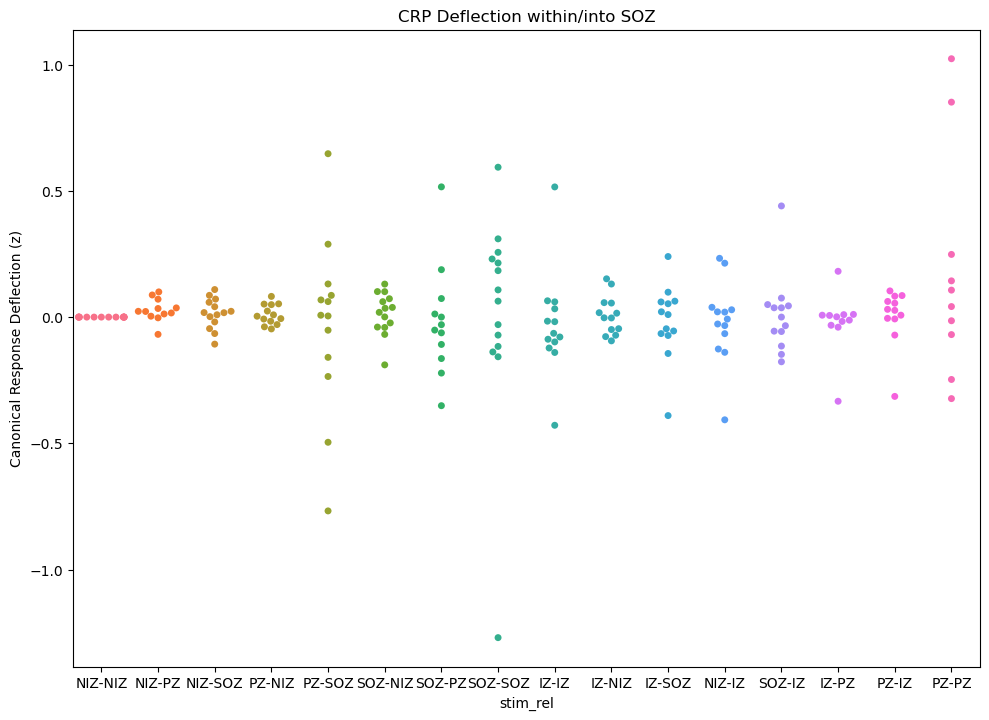

In [29]:
fig, ax = plt.subplots(figsize=[11.7,8.27])


ax = sns.swarmplot(tst_df, x='stim_rel', y='alpha_z',hue='stim_rel',ax=ax)
a = tst_df[tst_df.stim_rel=='NIZ-SOZ'].alpha_z
b = tst_df[tst_df.stim_rel =='SOZ-SOZ'].alpha_z
c = tst_df[tst_df.stim_rel == 'SOZ-NIZ'].alpha_z
d =  tst_df[tst_df.stim_rel == 'PZ-PZ'].alpha_z

b= ttest_1samp(b,0)
print(f"SOZ mean : {np.mean(b)} vs NIZ->SOZ mean {np.mean(a)}")

print(f"SOZ->NIZ: {np.mean(c)} vs NIZ->SOZ mean {np.mean(a)}")
print(ttest_ind(a,b))
# print(ttest_1samp(c,0))
# print(ttest_1samp(d,0) )


plt.ylabel("Canonical Response Deflection (z)")
plt.title("CRP Deflection within/into SOZ")
plt.savefig("crp_z.pdf")

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


TtestResult(statistic=-1.4334854702970352, pvalue=0.16363614505042262, df=26.0)


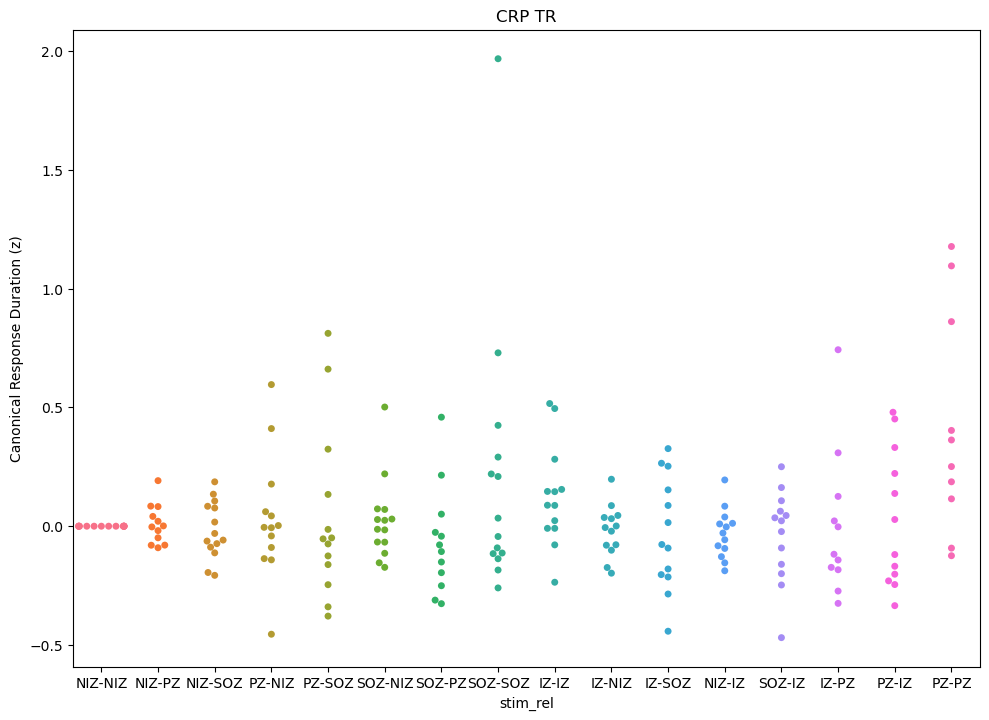

In [24]:
fig, ax = plt.subplots(figsize=[11.7,8.27])


ax = sns.swarmplot(tst_df, x='stim_rel', y='TR_z',hue='stim_rel',ax=ax)
a = tst_df[tst_df.stim_rel=='NIZ-SOZ'].TR_z
b = tst_df[tst_df.stim_rel =='SOZ-SOZ'].TR_z
c = tst_df[tst_df.stim_rel == 'PZ-SOZ'].TR_z
d =  tst_df[tst_df.stim_rel == 'PZ-PZ'].TR_z

# b= ttest_1samp(b,0)
# print(b)
print(ttest_ind(a,b))
# print(ttest_1samp(c,0))
# print(ttest_1samp(d,0) )


plt.ylabel("Canonical Response Duration (z)")
plt.title("CRP TR")
plt.savefig("crp_TRz.pdf")

TtestResult(statistic=-4.846035453436359, pvalue=5.0454892098212625e-05, df=26.0)


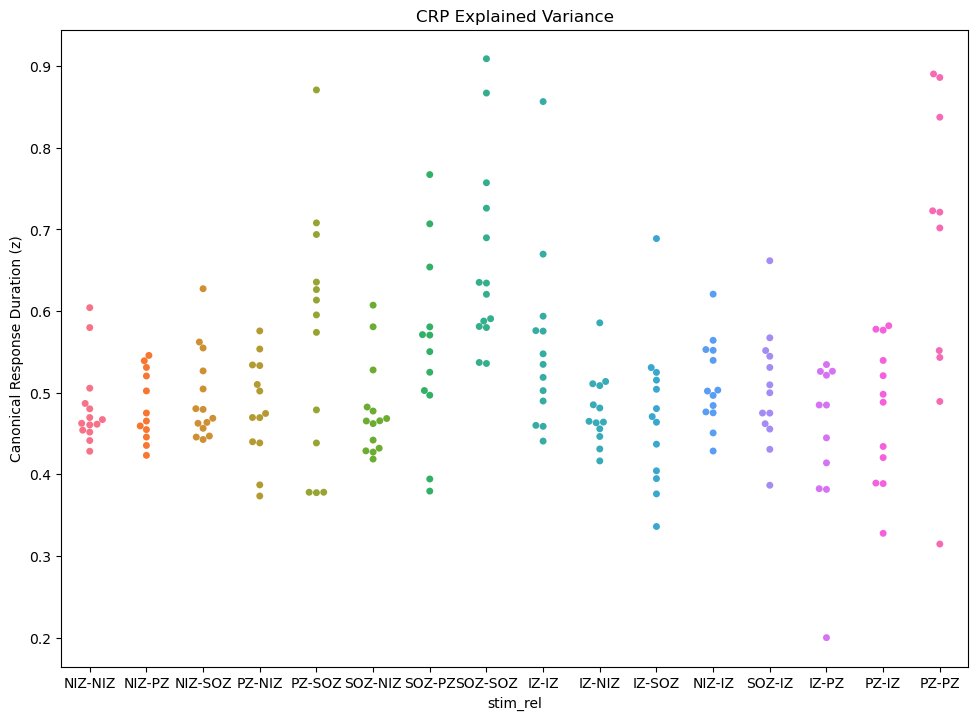

In [26]:

fig, ax = plt.subplots(figsize=[11.7,8.27])


ax = sns.swarmplot(tst_df, x='stim_rel', y='explained_variance',hue='stim_rel',ax=ax)
a = tst_df[tst_df.stim_rel=='NIZ-SOZ'].explained_variance
b = tst_df[tst_df.stim_rel =='SOZ-SOZ'].explained_variance
c = tst_df[tst_df.stim_rel == 'PZ-SOZ'].explained_variance
d =  tst_df[tst_df.stim_rel == 'PZ-PZ'].explained_variance

# b= ttest_1samp(b,0)
# print(b)
print(ttest_ind(a,b))
# print(ttest_1samp(c,0))
# print(ttest_1samp(d,0) )


plt.ylabel("Canonical Response Duration (z)")
plt.title("CRP Explained Variance")
plt.savefig("crp_TRz.pdf")

array([['SOZ', 'NIZ'],
       ['SOZ', 'NIZ'],
       ['SOZ', 'NIZ'],
       ...,
       ['NIZ', 'NIZ'],
       ['NIZ', 'NIZ'],
       ['NIZ', 'NIZ']], dtype=object)

Text(0.5, 1.0, 'TR Across all locations')

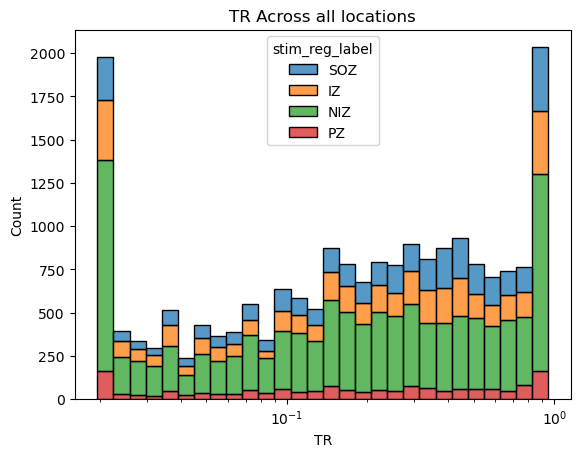

In [85]:
sns.histplot(data=group_df, x= 'TR', hue='stim_reg_label',multiple='stack',log_scale=True)
plt.title("TR Across all locations")

In [86]:
group_df[['TR']].describe()

,TR
count,20008.000000
mean,0.311865
std,0.290119
min,0.019531
25%,0.070312
50%,0.207031
75%,0.476562
max,0.949219


Text(0.5, 1.0, 'Alpha prime Across all locations')

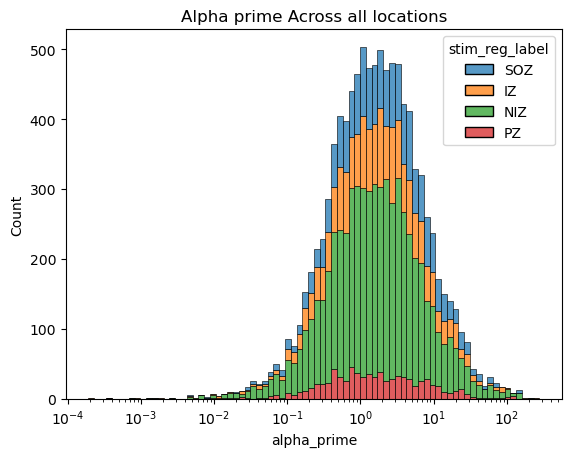

In [87]:
sns.histplot(data=group_df, x= 'alpha_prime', hue='stim_reg_label',multiple='stack',log_scale=True)
plt.title("Alpha prime Across all locations")

Text(0.5, 1.0, 'Alpha prime in SOZ locations')

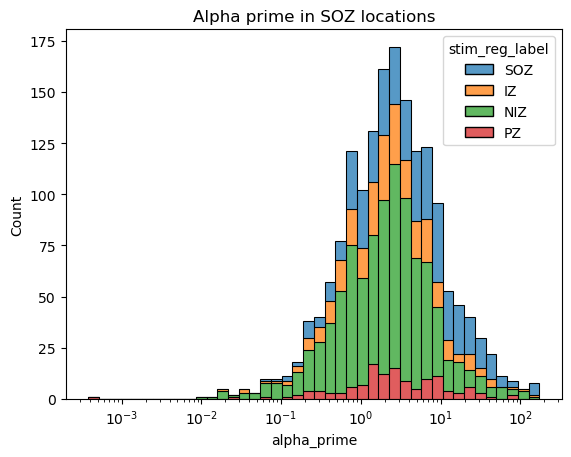

In [88]:
tst = group_df.reset_index()
tst = tst[tst.resp_reg_label =='SOZ']
sns.histplot(data=tst, x= 'alpha_prime', hue='stim_reg_label',multiple='stack',log_scale=True)
plt.title("Alpha prime in SOZ locations")

Text(0.5, 1.0, 'Alpha prime in PZ locations')

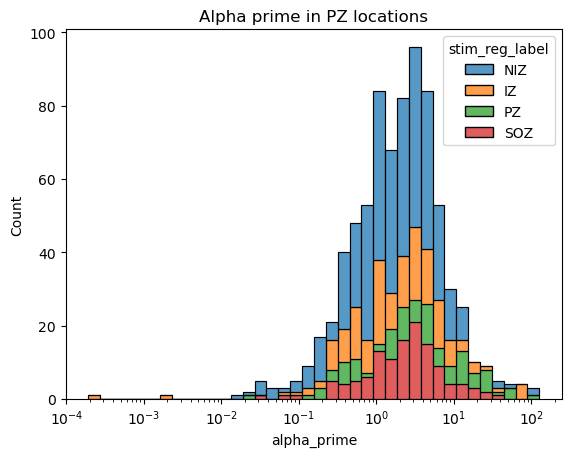

In [89]:
tst = group_df.reset_index()
tst = tst[tst.resp_reg_label =='PZ']
sns.histplot(data=tst, x= 'alpha_prime', hue='stim_reg_label',multiple='stack',log_scale=True)
plt.title("Alpha prime in PZ locations")


<Axes: xlabel='resp_reg_label', ylabel='alpha_prime'>

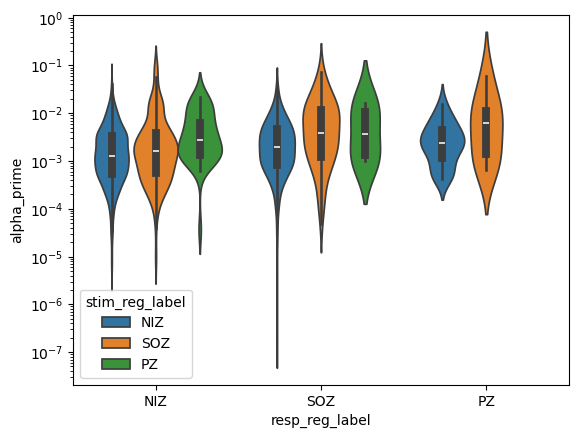

In [90]:
sns.violinplot(plot_df[plot_df.subj==plot_df.subj.values[0]],x='resp_reg_label', y='alpha_prime', hue='stim_reg_label', log_scale=True)


In [91]:
set(group_df.reset_index().subj)

{'Epat27', 'Epat30', 'Epat31', 'Spat30', 'Spat34'}

Text(0.5, 1.0, 'Epat 27')

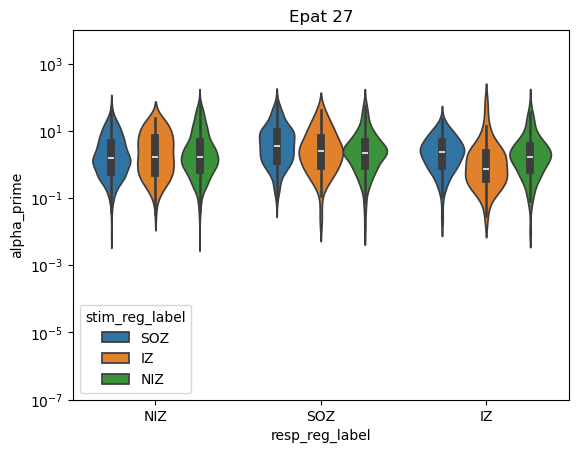

In [97]:

ax = sns.violinplot(plot_df[plot_df.subj=='Epat27'],x='resp_reg_label', y='alpha_prime', hue='stim_reg_label', log_scale=True)
ax.set_ylim(10e-8, 10e3)
plt.title("Epat 27")

Text(0.5, 1.0, 'Epat 30')

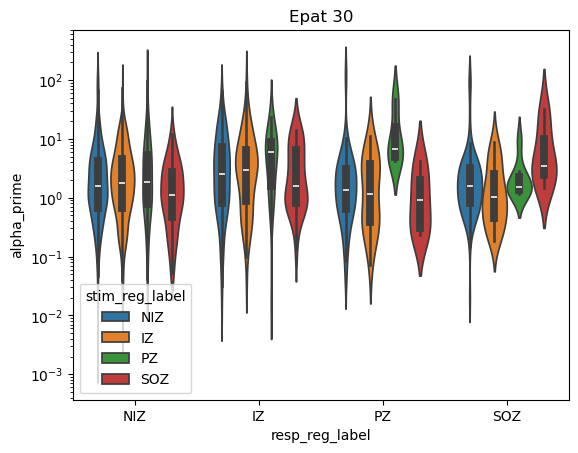

In [98]:

sns.violinplot(plot_df[plot_df.subj=='Epat30'],x='resp_reg_label', y='alpha_prime', hue='stim_reg_label', log_scale=True)
ax.set_ylim(10e-8, 10e3)
plt.title("Epat 30")

Text(0.5, 1.0, 'Epat 31')

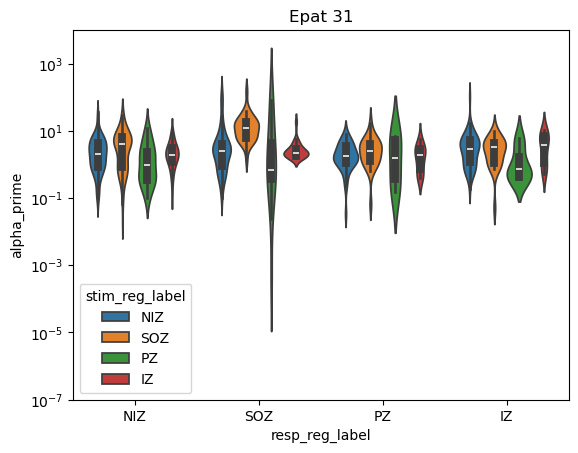

In [99]:

ax= sns.violinplot(plot_df[plot_df.subj=='Epat31'],x='resp_reg_label', y='alpha_prime', hue='stim_reg_label', log_scale=True)
ax.set_ylim(10e-8, 10e3)
plt.title("Epat 31")

Text(0.5, 1.0, 'Spat 30')

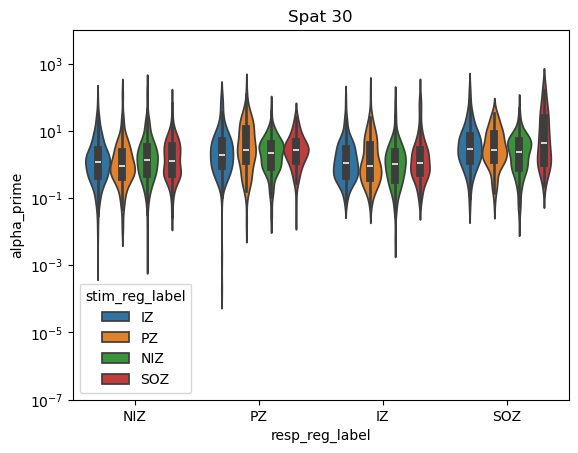

In [100]:
ax= sns.violinplot(plot_df[plot_df.subj=='Spat30'],x='resp_reg_label', y='alpha_prime', hue='stim_reg_label', log_scale=True)
ax.set_ylim(10e-8, 10e3)
plt.title("Spat 30")

Text(0.5, 1.0, 'Spat 34')

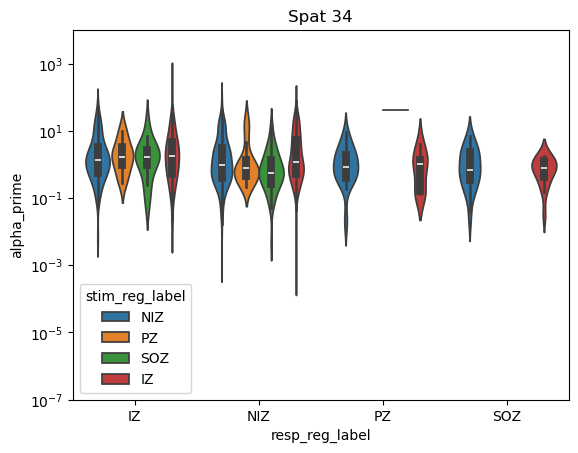

In [101]:

ax= sns.violinplot(plot_df[plot_df.subj=='Spat34'],x='resp_reg_label', y='alpha_prime', hue='stim_reg_label', log_scale=True)
ax.set_ylim(10e-8, 10e3)
plt.title("Spat 34")

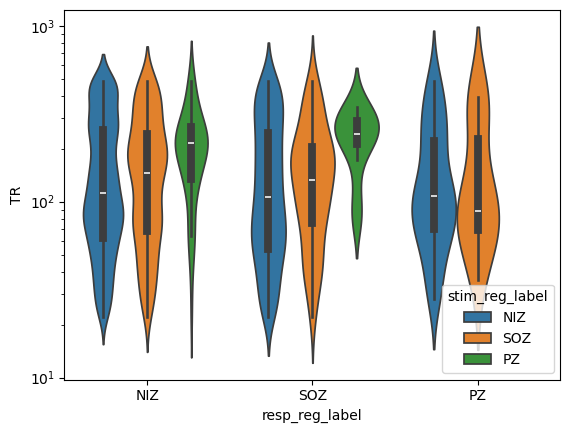

In [43]:
sns.violinplot(group_df.reset_index(),x='resp_reg_label', y='TR', hue='stim_reg_label', log_scale=True)
plot_df = group_df.reset_index()

In [25]:
sns.boxplot(plot_df,x='resp_reg_label', y='alpha_prime_log', hue='stim_reg_label')

ValueError: Could not interpret value `alpha_prime_log` for `y`. An entry with this name does not appear in `data`.

In [27]:
plot_df

,subj,resp_reg,stim_reg,resp_reg_label,stim_reg_label,alphas,alpha_prime,TR,dist
0,Epat26,LA2,LA3-LA4,NIZ,NIZ,-2746.491789,-0.011038,486.000000,6.7946
1,Epat26,LA2,LA5-LA6,NIZ,NIZ,2745.715562,0.011034,486.000000,13.9337
2,Epat26,LA2,LAC1-LAC2,NIZ,NIZ,31.896459,0.002225,28.000000,69.0552
3,Epat26,LA2,LAC3-LAC4,NIZ,NIZ,-6.865667,-0.001341,10.000000,70.6798
4,Epat26,LA2,LAC5-LAC6,NIZ,NIZ,34.532550,0.001606,42.000000,72.9909
...,...,...,...,...,...,...,...,...,...
25333,Spat34,PT5,PE9-PE10,NIZ,NIZ,-193.847065,-1.140277,0.332031,25.5395
25334,Spat34,PT5,PI4-PI5,NIZ,NIZ,-50.024949,-0.116337,0.839844,22.4516
25335,Spat34,PT5,PI6-PI7,NIZ,NIZ,46.217589,0.159371,0.566406,27.3713
25336,Spat34,PT5,PI8-PI9,NIZ,NIZ,-7.857135,-0.357143,0.042969,33.1437


<Axes: xlabel='TR', ylabel='alpha_prime'>

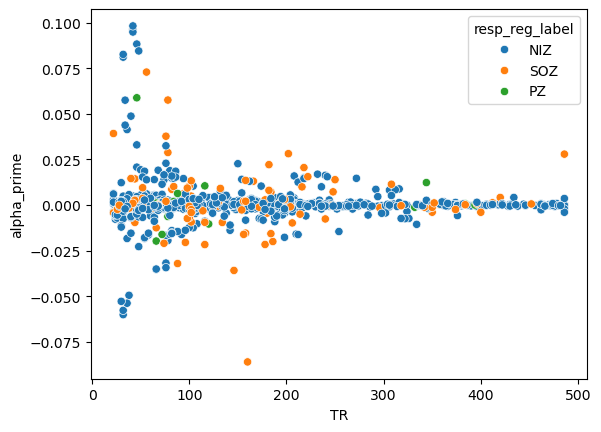

In [44]:
sns.scatterplot(data=plot_df[plot_df.stim_reg_label =='SOZ'], x='TR',y='alpha_prime',hue='resp_reg_label')

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

<Axes: xlabel='TR', ylabel='alpha_prime'>

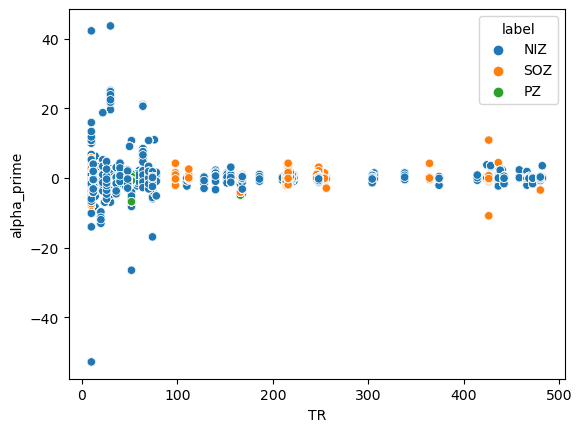

In [ ]:
sns.scatterplot(data=plot_df[plot_df.stim_label =='NIZ'], x='TR',y='alpha_prime',hue='label')